Los árboles de decisión son representaciones gráficas de posibles soluciones a una decisión basada en ciertas condiciones, es uno de los algoritmos de aprendizaje supervizado más utilizados en machine learning y puede realizar tareas de clasificación o regresión.

Los árboles de decisión tienen un primer nodo llamado raíz (root) y luego se descomponen el resto de atributos de entrada en dos ramas (podrían ser más de dos ramas) planteando una condición que puede ser cierta o falsa. Se bifurca cada nodo en 2 y vuelven a sudividirse hasta llegar a las hojas que son los nodos finales y que equivalen a la solución (Si/No, Comprar/Vender).

El algoritmo es quien analiza los datos y las salidad, por eso es supervizado, dicidirá la mejor forma de hacer las divisiones (splits) entre nodos. Tendrá en cuenta de qué manera lograr una predicción (clasificación o regresión)

¿Cómo funciona un árbol de decisión?

Para obtener el árbol óptimo y valorar cada subdivisión entre todos los árboles posibles y conseguir el nodo raiz y los subsiguientes, el algoritmo deberá medir de alguna manera las predicciones logradas y valorarlas para comparar de entre todas y obtener la mejor. Para medir y valorar, utiliza diversas funciones, siendo las más conocidas y usadas los "indice gini" y "ganancia de información" que utiliza la denominada entropia. La división de nodos continuará hasta que lleguemos a la profundidad máxima posible del árbol o se limiten los nodos a una cantidad mínima de muestras de cada hoja.

* Indice Gini

Se utiliza para atributos con valores continuos (Ej: precio de una casa). Esta función de coste mide el "grado de impureza" de los nodos, es decir, cuán desordenados o mezclados quedan los nodos una vez divididos. Deberemos minimizar ese GINI index.

* Ganancia de información:

Se utiliza para atributos categóricos (Ej: hombre/mujer). Este criterio intenta estimar la información que aporta cada atributo basado en la "teoría de la información". Para medir la aleatoriedad de incertidumbre de un valor aleatorio de una variable "X" se define Entropia. Al obtener la medida de entropía de cada atributo, podemos calcular la ganancia de información del árbol. Debemos maximizar esa ganancia.

In [14]:
# Carga las librerias de trabajo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from subprocess import check_call


Se utilizó un código python para hacer webscraping de una web pública "Ultimate Music Database" con información histórica edl Billboard del artículo: "Analyzing billboard 100". Luego se completo atributos utilizando la API de Deezer (duración de las canciones), la API de Gracenote (género y ritmo de las canciones). Finalmente se agrego varias fechar de nacimiento de artistas utilizando la Wikipedia. Algunos artistas quedaron sin completar su fecha de nacimiento y con valor cero. 

In [15]:
# Carga el dataset
data = pd.read_csv('artists_billboard_fix3.csv')

# Muestra las primeras filas
data.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


A partir de atributos de cantantes y de un histórico de canciones que alcanzaron entrar al Billboard 100 (U.S) en 2013 y 2014 crearemos un árbol que nos permita intentar predecir si un nuevo cantante podrá llegar a número uno.

In [16]:
# Muestra el tamaño del dataset
data.shape

(635, 11)

In [17]:
data. columns

Index(['id', 'title', 'artist', 'mood', 'tempo', 'genre', 'artist_type',
       'chart_date', 'durationSeg', 'top', 'anioNacimiento'],
      dtype='object')

El dataframe esta compuesto de 11 columnas (features) y 635 filas. Se tiene: titulo de canción, artista, mood o estado de animo de la canción, tempo, género, tipo de artista, fecha en que apareció en el billboard (Ej: 20140628 equivale al 28 de junio de 2024), la columna top la cual será la equiqueta, en la que aparece 1 si llegó al número uno de Billboard o 0 si no alcanzó, por último el año de nacimiento del artista. 

La mayoria de las columnas contiene información categórica. La columna durationSeg contiene la duración en segundos de la canción, siendo un valor continuo pero que convendrá pasar a categórico más adelante.

In [18]:
# Agurpa el dataset por el campo "top"
data.groupby('top').size()

top
0    494
1    141
dtype: int64

Devuelve que tenemos 494 canciones que no alcanzaron la cima y a 141 que alcanzaron el número uno. Esto quiere decir que tenemos una cantidad desbalanceada de etiquetas con 1 y 0.

## Visualización de los atributos de entrada

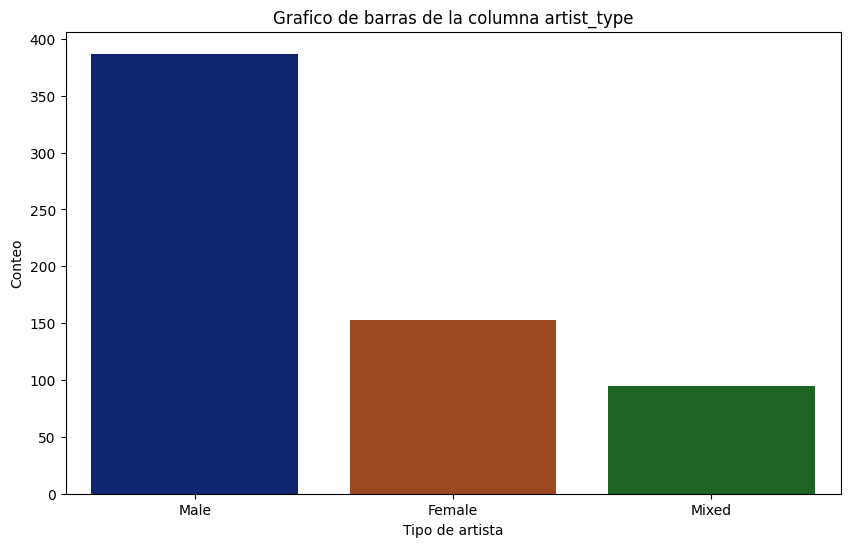

In [19]:
# Grafica de la columna artist_type
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='artist_type', palette='dark')

plt.title('Grafico de barras de la columna artist_type')
plt.xlabel('Tipo de artista')
plt.ylabel('Conteo')
plt.show()

Se observa que tenemos más del doble de artistas masculinos que femeninos y unos 100 registros de canciones mixtas.

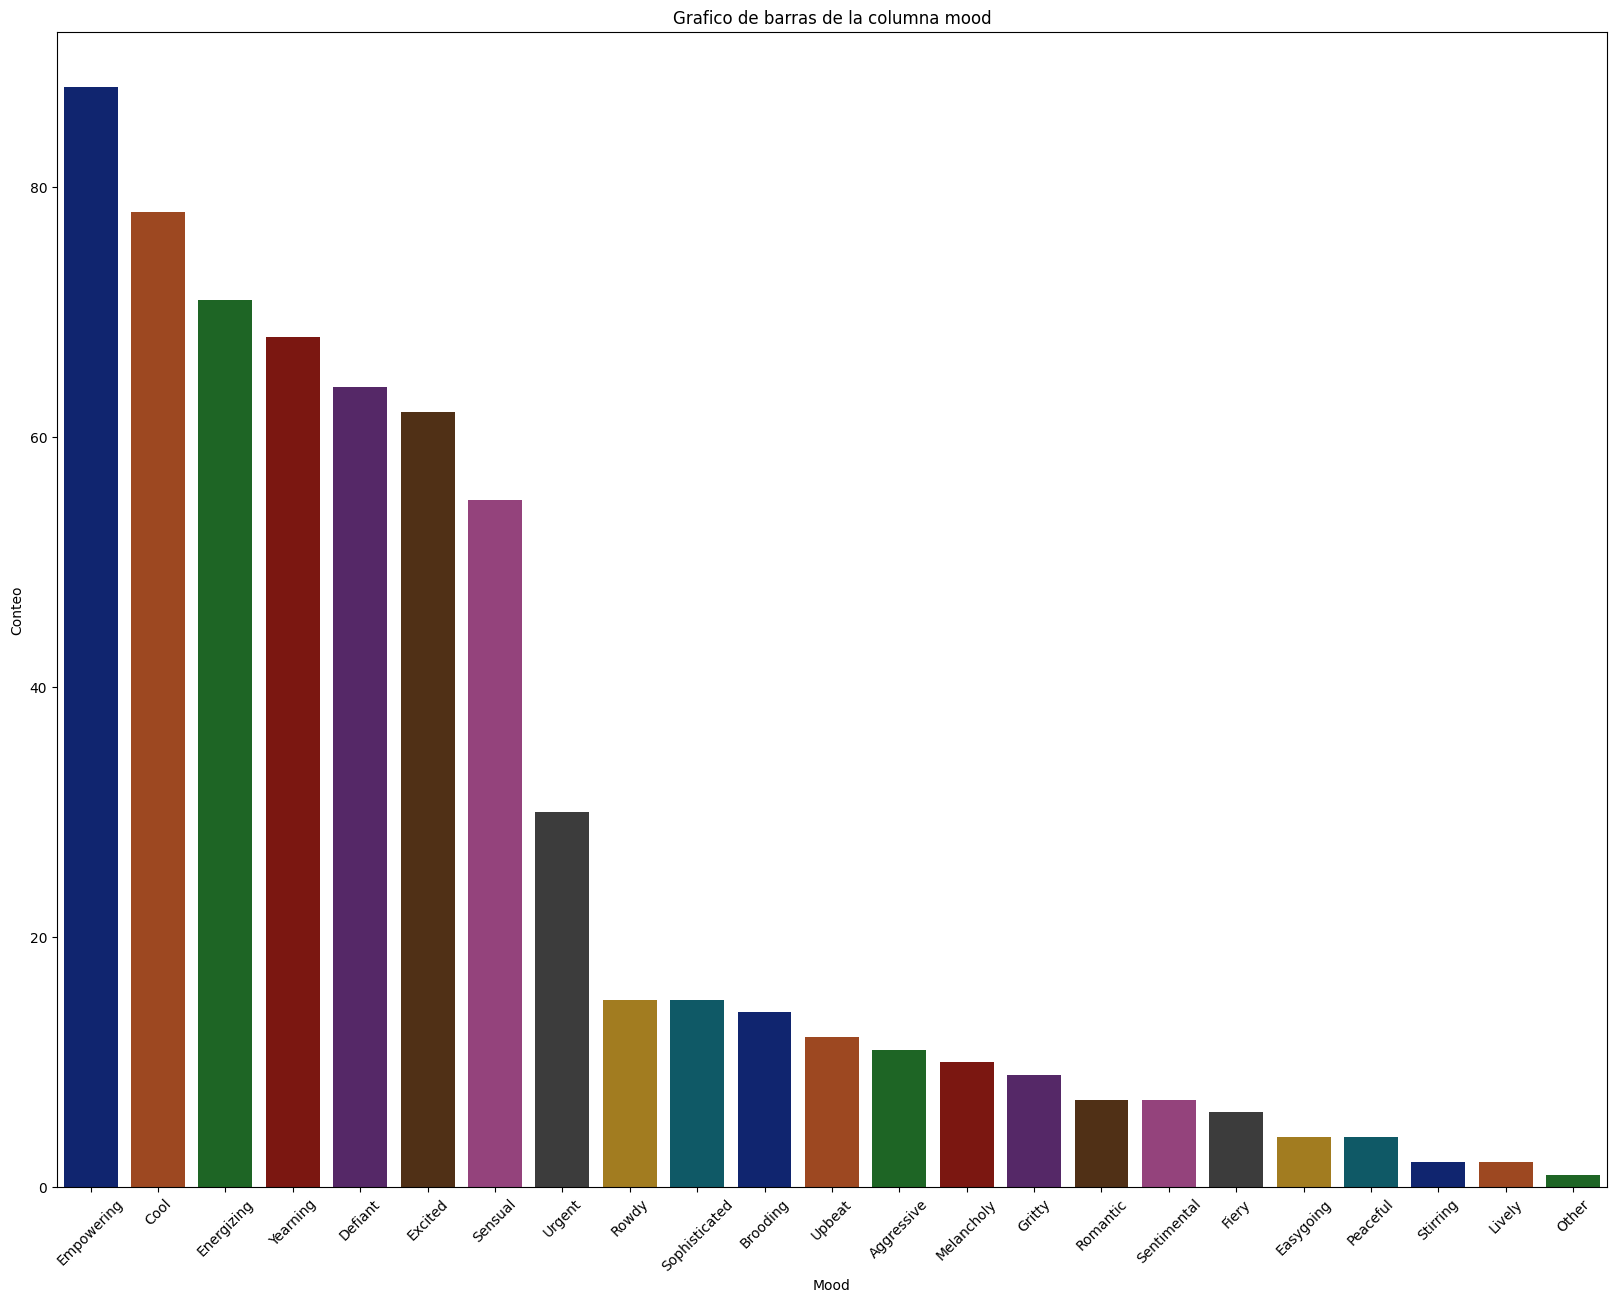

In [20]:
plt.figure(figsize=(20, 15))
plt.xticks(rotation=45)
sns.countplot(data=data, x='mood', order=data['mood'].value_counts().index, palette='dark')
plt.title('Grafico de barras de la columna mood')
plt.xlabel('Mood')
plt.ylabel('Conteo')
plt.show()

Se observan 23 tipos de Mood, destacando 7 con picos altos y varios estados de ánimo similares.

<Axes: xlabel='tempo', ylabel='count'>

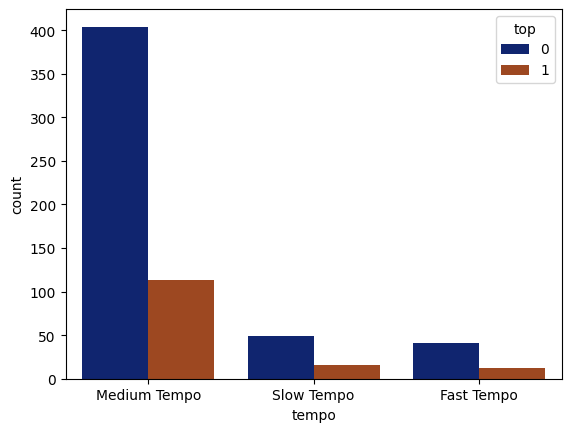

In [21]:
# Grafica de la columna tempo dividido por la columna top
sns.countplot(data=data, x='tempo', hue='top', palette='dark')

En esta gráfica se observa que hay 3 tipos distintos de tempo: Medim, Slow y Fast. Predomina el tempo Medium y es donde encontramos más canciones que hayan alcanzado el Top 1.

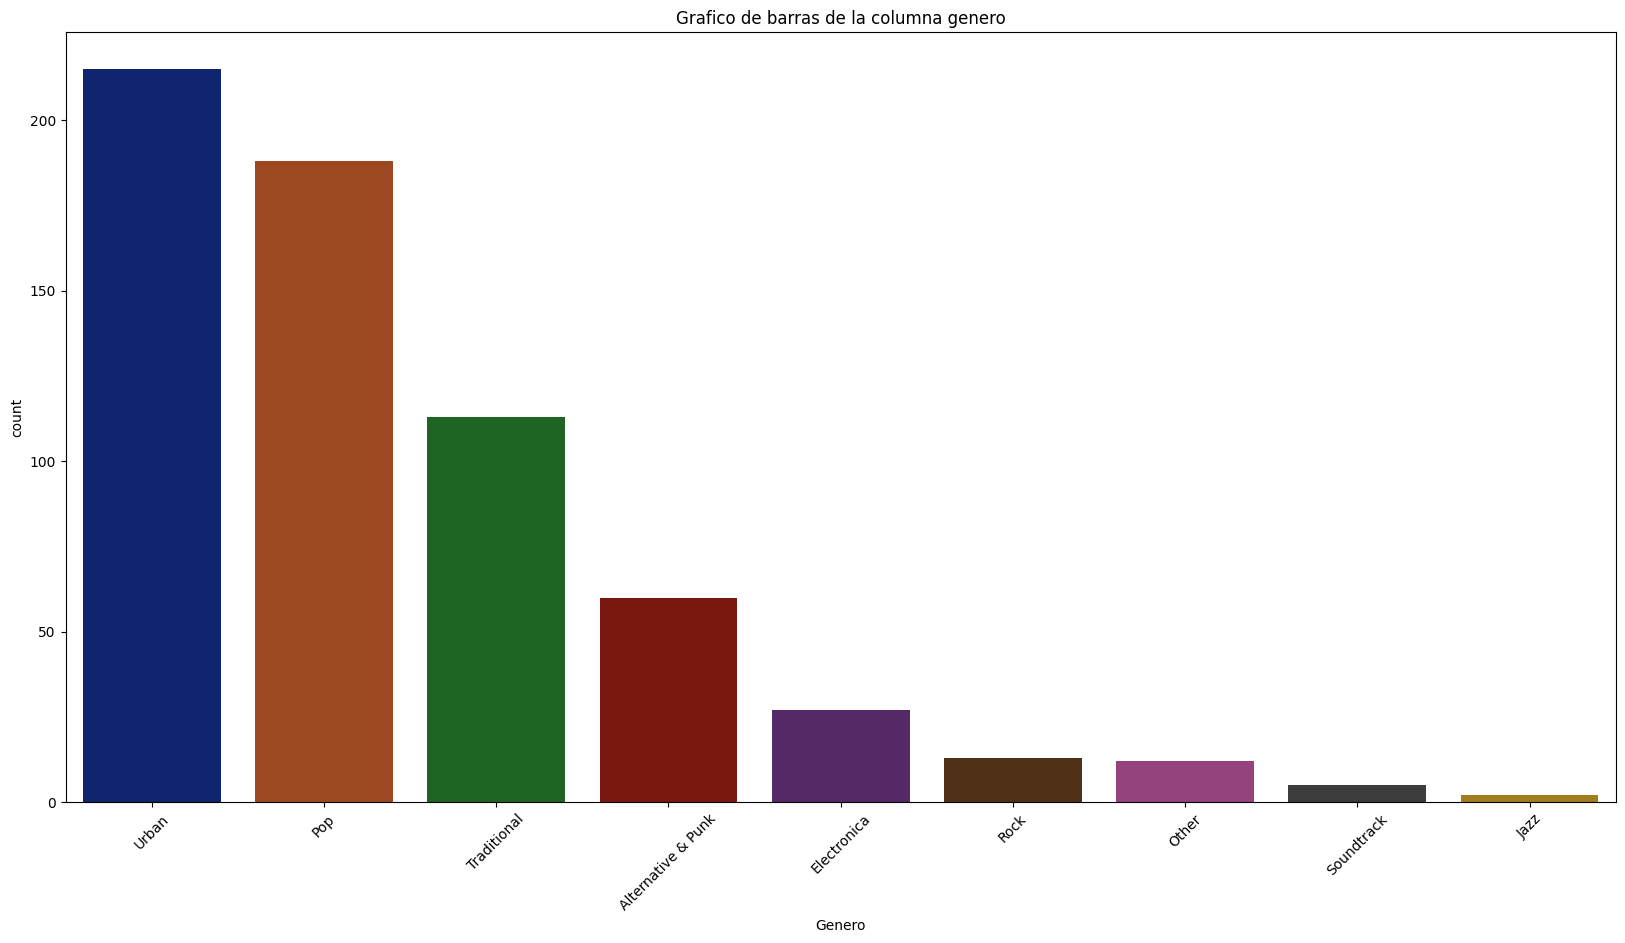

In [22]:
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='genre', order=data['genre'].value_counts().index,palette='dark')
plt.xticks(rotation=45)
plt.title('Grafico de barras de la columna genero')
plt.xlabel('Genero')
plt.show()

Entre los generos musicales destacan Urban, Pop y Tradicional.

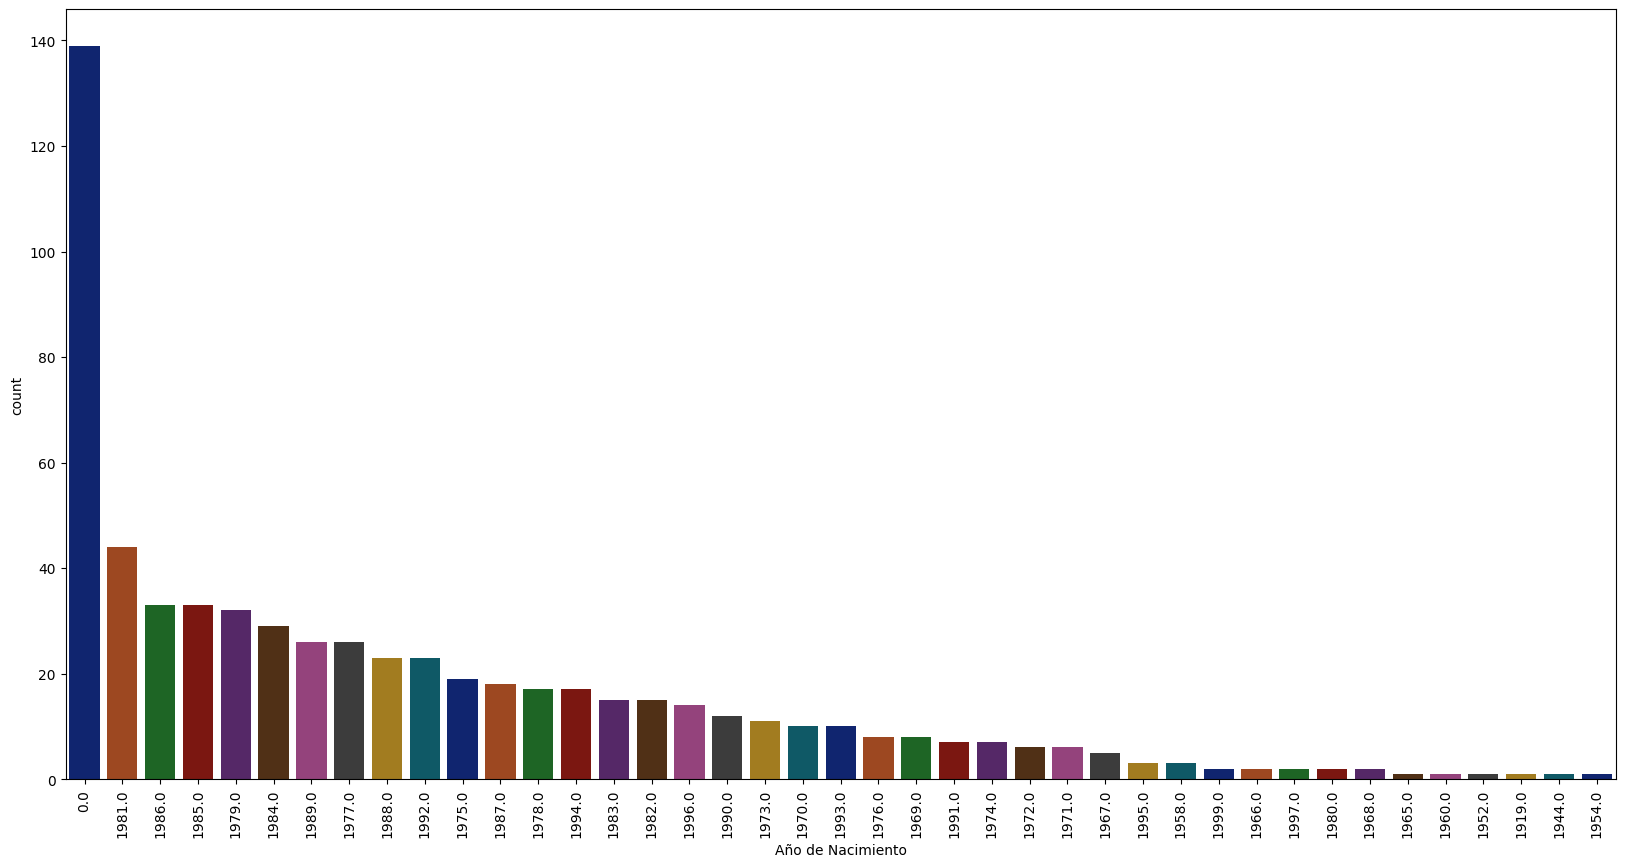

In [23]:
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='anioNacimiento', order=data['anioNacimiento'].value_counts().index, palette='dark')
plt.xticks(rotation=90)
plt.xlabel('Año de Nacimiento')
plt.show()

Se observan en la gráfica que hay cerca de 140 canciones de las cuales se desconoce el año de nacimiento del artista. Además, se ve que los años de nacimiento de los artista va desde 1954 a 1981.

## Balanceo de datos

Como se observo antes, no tenemos "equilibrio" en la cantidad de etiquetas 'top' y 'no top' de las canciones. Esto se debe a que en el transcurso de un año, pocas canciones logran el primer puesto y se mantiene durante varias semanas en ese puesto. 

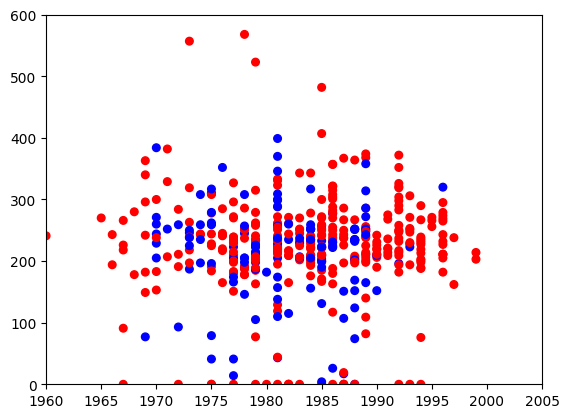

In [24]:
colores = ['red', 'blue']

# visualización de top y no top de acuerdo a su fecha de chart
f1 = data['anioNacimiento'].values
f2 = data['durationSeg'].values

asignar = []
for index, row in data.iterrows():
    asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([1960, 2005, 0, 600])
plt.show()

No se observa ningún patron a simple vista, los top y no tops están bien distribuidos.

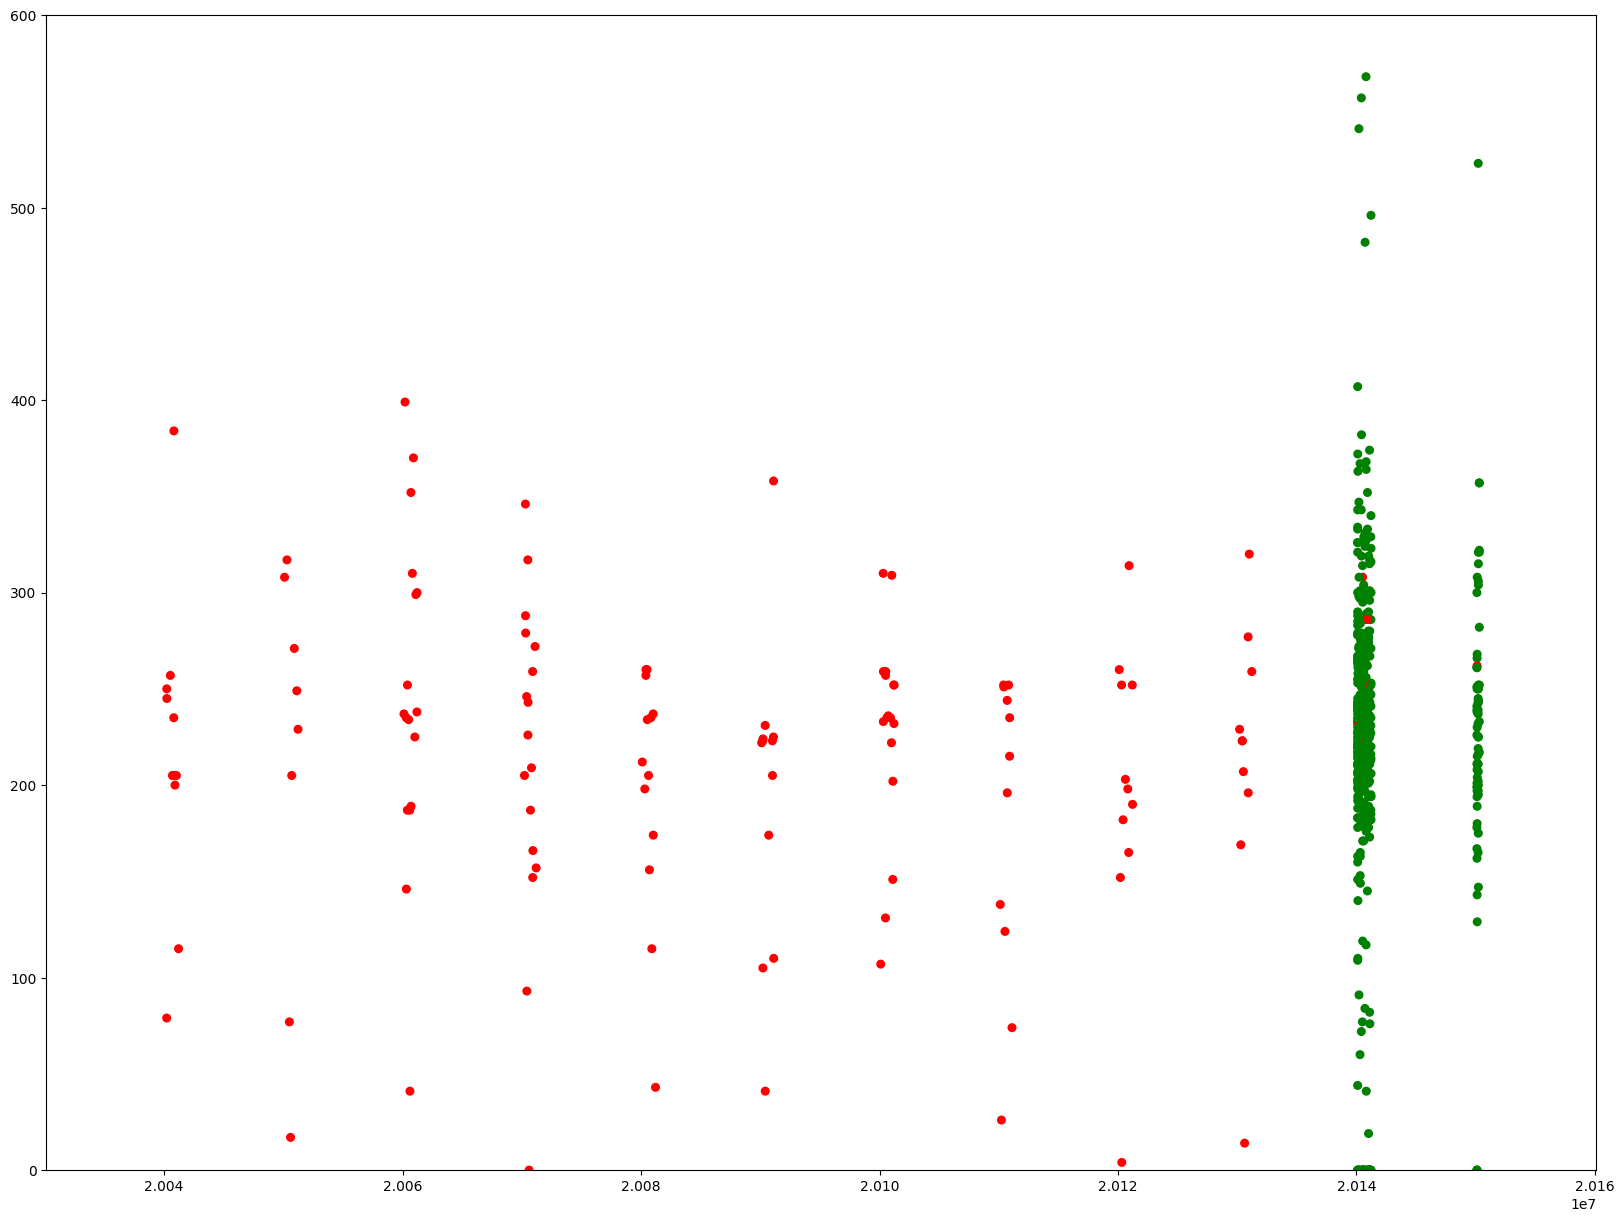

In [37]:
colores = ['green', 'red']
tamanios = [30, 30]
plt.figure(figsize=(20, 15))

f1 = data['chart_date'].values
f2 = data['durationSeg'].values

asignar = []
asignar2 = []
for index, row in data.iterrows():
    asignar.append(colores[row['top']])
    asignar2.append(tamanios[row['top']])

plt.scatter(f1, f2, c=asignar, s=asignar2)
plt.axis([20030101,20160101,0,600])
plt.show()

## Preparación de los datos

Primero se procede a arreglar los años de nacimiento que están en cero. El "feature" o característica que queremos obtener es: "sabiendo el año de nacimiento del cantante, calcular que edad tenía al momento de aparecer en el Billboard". Por ejemplo un artista que nació en 1982 y apareció en los charts en 2012, tenía 30 años.

In [38]:
# Función para cambiar el anio de nacimiento de cero a None
def edad_fix(anio):
    if anio == 0:
        return None
    return anio

data['anioNacimiento']= data.apply(lambda x: edad_fix(x['anioNacimiento']), axis=1);

In [39]:
def calcular_edad(anio, cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio ==0.0:
        return None
    return int(momento) - anio

data['edad_en_billboard'] = data.apply(lambda x: calcular_edad(x['anioNacimiento'], x['chart_date']), axis=1)

In [40]:
data.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN,NaN
